<a href="https://colab.research.google.com/github/Ignacioruuizm/BD_MACHINELEARNING_V4/blob/main/machineV2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

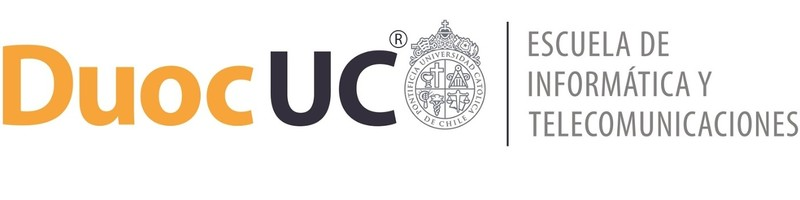



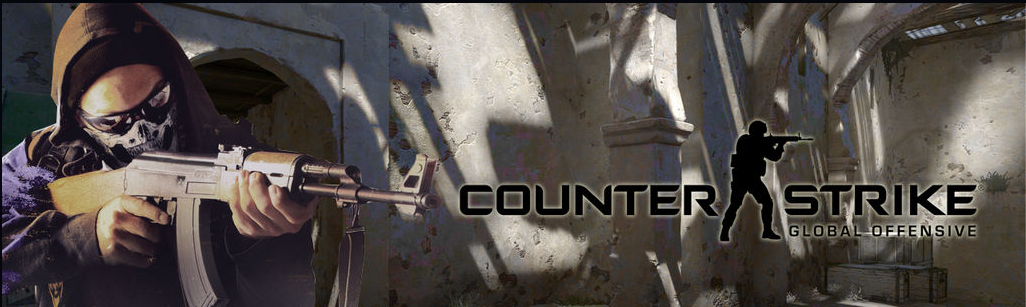

# Informe Técnico - Examen Transversal: Caso Counter Strike


Integrantes:
* Ignacio Ruiz
* Pedro Barrientos
* Pablo Riquelme

Docente: Giocrisrai Godoy

Sección: MLY0100 -

# Caso Fundamentos de Machine Learning

CONTEXTO CASO

Valve, los ha contactado como equipo de análisis de datos y modelado de Machine Learning para analizar y realizar modelos predictivos sobre los datos.

En cada partida de Counter Strike: GO dos equipos de 5 jugadores (denominados terroristas y contra-terroristas) se enfrentan.


El objetivo del equipo terrorista es plantar una bomba con timer de 45 segundos en uno de dos sitios específicos dentro de un mapa. Por otro lado, el objetivo del equipo contra-terrorista es evitar que la bomba sea plantada o desactivarla antes de que esta explote cuando ya ha sido plantada. Los datos a utilizar corresponden a sobre 7000 partidas del juego (con un máximo de 10 jugadores c/u)  


Los datos han sido extraídos de replays, los cuales son archivos propietarios con la información de cada una de las acciones realizadas por cada jugador dentro de una partida. Los replays han sido extraídos de la red utilizando un scrapper y pre-procesados utilizando un script.  



En este caso, la data corresponde a un archivo CSV con 79.157 filas, cada una correspondiente a un jugador dentro de una partida. El archivo contiene 29 columnas correspondientes a variables que describen las acciones del jugador dentro del juego.


$$
\begin{aligned}
&\begin{array}{cccc}
\hline \hline \text { Dato } & \text { Descripción } \\
\hline Map & \text {Nombre  del Mapa donde se jugó la partida}  \\
\hline \text{ Team} & \text { Nombre de equipo al que pertenece el jugador} \\
\hline \text{ InternalTeamId} & \text { Identificador del equipo al que pertenece el jugador.} \\
\hline \text{ MatchId} & \text { Identificador de la partida.} \\
\hline \text{ RoundId} & \text { Identificador de la ronda (los equipos se enfrentan en rondas de 5 partidas seguidas)} \\
\hline \text{ MatchWinner} & \text { Indica si el jugador ganó o no la partida.} \\
\hline \text{ RoundWinner} & \text { Indica si el jugador ganó o no la ronda analizada.} \\
\hline \text{ Survived} & \text { Indica si el jugador sobrevivió o no a la partida (sobrevivir no es sinónimo de ganar).} \\
\hline \text{ AbnormalMatch} & \text { Indica si la partida del jugador tuvo un error por conexión de red} \\
\hline \text{ TimeAlive} & \text { Indica el tiempo en segundos que el jugador estuvo vivo durante el juego} \\
\hline \text{ TravelledDistance} & \text { Distancia viajada por el jugador durante la partida.} \\
\hline \text{ RLethalGrenadesThrown/RNonLethalGrenadesThrown} & \text { Cantidad de granadas lanzadas, categorizadas en letales y no-letales.} \\
\hline \text{ PrimaryXXXX} & \text { Porcentaje de uso arma clasificada como primaria. Categorizada en AssaultRifle, SniperRifle, SMG, Heavy y Pistol.} \\
\hline \text{ [Match|Round] Assists} & \text { Cantidad de asistencias efectuadas por el jugador durante la partida o la ronda.} \\
\hline \text{ [Match|Round] Kills} & \text { Cantidad de kills efectuados por el jugador durante la partida o la ronda.} \\
\hline \text{ [Match|Round] FlankKills} & \text { Cantidad de kills efectuados por el jugador sin que la víctima lo viese durante la partida o la ronda.} \\
\hline \text{ [Match|Round] HeadShots} & \text { Cantidad de kills efectuados por el jugador a través de un tiro en la cabeza durante la partida o la ronda.} \\
\hline \text{ RoundStartingEquipmentValue} & \text { Valor del equipamiento llevado por el jugador al inicio de la ronda.} \\
\hline \text{ TeamStartingEquipmentValue} & \text { Valor promedio del equipamiento llevado por el equipo del jugador al inicio de la ronda.} \\
\end{array}
\end{aligned}
$$

1. Contexto del Negocio

Valve Corporation ha solicitado apoyo en el análisis y modelado de datos de partidas de Counter Strike: Global Offensive CS:GO. Este videojuego competitivo enfrenta a dos equipos terroristas y contra-terroristas en múltiples rondas, donde cada jugador puede desempeñar un rol clave en el éxito o fracaso del equipo.

La empresa busca entender, a través de técnicas de *Machine Learning*, qué factores influyen en el rendimiento individual y colectivo de los jugadores, para poder:

- Mejorar la experiencia de juego.
- Detectar patrones de juego irregulares.
- Ajustar balanceos o detectar posibles trampas.
- Incorporar sistemas predictivos en emparejamiento y diseño de juego.

2. Comprensión del Problema

El dataset entregado cuenta con más de 79.000 registros, cada uno representando a un jugador en una ronda determinada. Contiene variables cuantitativas y categóricas sobre comportamiento, rendimiento, equipamiento, y estado del jugador y su equipo durante la partida.

**Desde una perspectiva de Machine Learning, podemos abordar el problema como:**
Nos enfocamos en predecir una variable objetivo relacionada con el rendimiento del jugador (por ejemplo, MatchKills o RoundStartingEquipmentValue) a partir de variables como TimeAlive, Score, ADR, entre otras.

Se trata de un problema de regresión supervisada, ya que la variable objetivo es continua. Aplicaremos distintos modelos de Machine Learning y compararemos sus rendimientos para identificar el más adecuado.




In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVR
from sklearn.preprocessing import RobustScaler
from sklearn.tree import DecisionTreeRegressor, plot_tree
from sklearn.model_selection import  GridSearchCV
from sklearn.metrics import mean_absolute_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.utils import resample
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import mean_squared_error, accuracy_score, confusion_matrix, classification_report
from sklearn.ensemble import RandomForestRegressor

# Subir archivo CSV
from google.colab import files
uploaded = files.upload()
# Leer el archivo corregido
df = pd.read_csv('Anexo_ET_demo_round_traces_2022_corregido.csv', low_memory=False)
# Eliminar columna de índice innecesaria si existe
if 'Unnamed: 0' in df.columns:
    df = df.drop(columns=['Unnamed: 0'])
# Vista previa del DataFrame
df.head()

Saving Anexo_ET_demo_round_traces_2022_corregido.csv to Anexo_ET_demo_round_traces_2022_corregido (7).csv


,600,de_inferno,Terrorist,1,4,1.1,False,True,False.1,False.2,...,0.1,0.2,0.3,0.4,750,4400,0.5,0.6,0.7,0.8
0,601,de_inferno,Terrorist,1,4,1,False,True,False,False,...,0,0,0,0,800,4400,0,0,0,0
1,602,de_inferno,Terrorist,1,4,1,False,True,False,False,...,0,0,0,0,1000,4400,0,0,0,0
2,603,de_inferno,Terrorist,1,4,1,False,True,False,False,...,0,0,0,0,850,4400,0,0,0,0
3,604,de_inferno,Terrorist,1,4,1,False,True,True,False,...,0,0,0,0,1000,4400,0,0,0,0
4,605,de_inferno,CounterTerrorist,2,4,1,True,False,True,False,...,0,0,0,0,850,3750,0,0,0,0


**1.- Limpieza de datos**

In [ ]:
# Nombres correctos de las columnas
column_names = [
    'PlayerId', 'Map', 'Team', 'InternalTeamId', 'MatchId', 'RoundId', 'RoundWinner',
    'MatchWinner', 'Survived', 'AbnormalMatch', 'TimeAlive', 'TravelledDistance',
    'RLethalGrenadesThrown', 'RNonLethalGrenadesThrown', 'PrimaryAssaultRifle',
    'PrimarySniperRifle', 'PrimaryHeavy', 'PrimarySMG', 'PrimaryPistol', 'FirstKillTime',
    'RoundKills', 'RoundAssists', 'RoundHeadshots', 'RoundFlankKills',
    'RoundStartingEquipmentValue', 'TeamStartingEquipmentValue', 'MatchKills',
    'MatchFlankKills', 'MatchAssists', 'MatchHeadshots'
]

# Leer archivo CSV sin encabezado y asignar nombres correctos
df = pd.read_csv('Anexo_ET_demo_round_traces_2022_corregido.csv', header=None, names=column_names)

# Ver resumen del dataset
original_shape = df.shape
print("Dimensiones originales:", original_shape)
print("\nValores nulos por columna:\n", df.isnull().sum())

# Columnas a convertir
cols_to_numeric = [
    'TimeAlive', 'TravelledDistance', 'RoundAssists', 'RoundHeadshots',
    'RoundStartingEquipmentValue', 'RoundKills', 'MatchKills', 'TeamStartingEquipmentValue'
]

# Convertir columnas a numéricas
for col in cols_to_numeric:
    if col in df.columns:
        df[col] = pd.to_numeric(df[col], errors='coerce')
    else:
        print(f"Warning: Column '{col}' not found in DataFrame.")

# Eliminar filas con nulos en variables clave
df = df.dropna(subset=['MatchKills', 'TeamStartingEquipmentValue'])

# Convertir 'Survived' a booleano si existe
if 'Survived' in df.columns:
    df['Survived'] = df['Survived'].astype(bool)

# Verificación final
print("\nDimensiones después de limpieza:", df.shape)
print(f"Filas eliminadas: {original_shape[0] - df.shape[0]}")

# Resumen estadístico
cols_to_describe = [col for col in cols_to_numeric if col in df.columns]
print("\nResumen estadístico:")
print(df[cols_to_describe].describe())


<ipython-input-90-d651fc2ac279>:13: DtypeWarning: Columns (6,7) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('Anexo_ET_demo_round_traces_2022_corregido.csv', header=None, names=column_names)


Dimensiones originales: (79157, 30)

Valores nulos por columna:
 PlayerId                       0
Map                            0
Team                           2
InternalTeamId                 0
MatchId                        0
RoundId                        0
RoundWinner                    0
MatchWinner                    1
Survived                       0
AbnormalMatch                  0
TimeAlive                      0
TravelledDistance              0
RLethalGrenadesThrown          0
RNonLethalGrenadesThrown       0
PrimaryAssaultRifle            0
PrimarySniperRifle             0
PrimaryHeavy                   0
PrimarySMG                     0
PrimaryPistol                  0
FirstKillTime                  0
RoundKills                     0
RoundAssists                   0
RoundHeadshots                 0
RoundFlankKills                0
RoundStartingEquipmentValue    0
TeamStartingEquipmentValue     0
MatchKills                     0
MatchFlankKills                0
MatchAssist

**Grafico limpieza de datos**

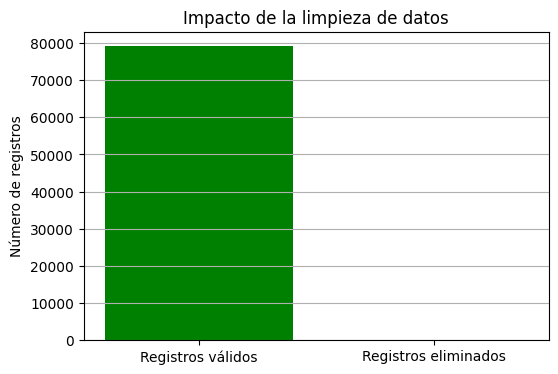

In [ ]:
# Visualizar impacto de la limpieza de datos
registros_validos = df.shape[0]
registros_eliminados = original_shape[0] - registros_validos

etiquetas = ['Registros válidos', 'Registros eliminados']
valores = [registros_validos, registros_eliminados]

plt.figure(figsize=(6,4))
plt.bar(etiquetas, valores, color=['green', 'red'])
plt.title("Impacto de la limpieza de datos")
plt.ylabel("Número de registros")
plt.grid(axis='y')
plt.show()


**2.-Regresión lineal simple**

MSE: 37.5177
Coeficiente (pendiente): 0.0001
Intercepto: 6.3668


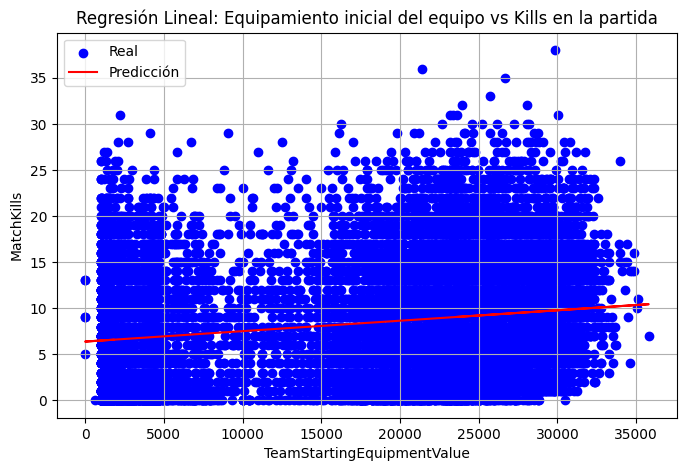

In [ ]:
# Asegurar que los datos sean numéricos
df['MatchKills'] = pd.to_numeric(df['MatchKills'], errors='coerce')
df['TeamStartingEquipmentValue'] = pd.to_numeric(df['TeamStartingEquipmentValue'], errors='coerce')

# Eliminar registros con valores nulos
df = df.dropna(subset=['MatchKills', 'TeamStartingEquipmentValue'])

# Definir variable independiente (X) y dependiente (y)
X = df[['TeamStartingEquipmentValue']]
y = df['MatchKills']
# Asegurar que los datos sean numéricos
df['MatchKills'] = pd.to_numeric(df['MatchKills'], errors='coerce')
df['TeamStartingEquipmentValue'] = pd.to_numeric(df['TeamStartingEquipmentValue'], errors='coerce')

# Eliminar registros con valores nulos
df = df.dropna(subset=['MatchKills', 'TeamStartingEquipmentValue'])

# Definir variable independiente (X) y dependiente (y)
X = df[['TeamStartingEquipmentValue']]
y = df['MatchKills']

# Dividir en entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Crear y entrenar modelo
lr = LinearRegression()
lr.fit(X_train, y_train)

# Predicciones
y_pred = lr.predict(X_test)

# Evaluación
print(f"MSE: {mean_squared_error(y_test, y_pred):.4f}")
print(f"Coeficiente (pendiente): {lr.coef_[0]:.4f}")
print(f"Intercepto: {lr.intercept_:.4f}")

# Visualización
plt.figure(figsize=(8, 5))
plt.scatter(X_test, y_test, color='blue', label='Real')
plt.plot(X_test, y_pred, color='red', label='Predicción')
plt.xlabel('TeamStartingEquipmentValue')
plt.ylabel('MatchKills')
plt.title('Regresión Lineal: Equipamiento inicial del equipo vs Kills en la partida')
plt.legend()
plt.grid(True)
plt.show()


**3.- Regresión lineal multiple**

📊 MSE (Regresión múltiple): 57.9617

🔍 Coeficientes de cada variable:
TeamStartingEquipmentValue: -0.0005
RoundStartingEquipmentValue: 0.0015
TimeAlive: -0.2709
TravelledDistance: 0.0000

Intercepto: 5.2807


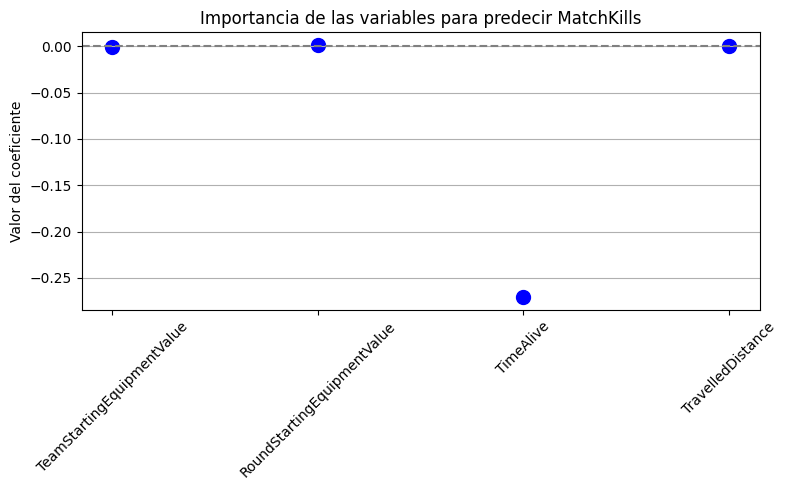

In [ ]:
# Variables predictoras
features = [
    'TeamStartingEquipmentValue',
    'RoundStartingEquipmentValue',
    'TimeAlive',
    'TravelledDistance'
]

# Asegurarse de que las columnas sean numéricas
df[features + ['MatchKills']] = df[features + ['MatchKills']].apply(pd.to_numeric, errors='coerce')

# Eliminar filas con valores faltantes
df = df.dropna(subset=features + ['MatchKills'])

# Separar X e y
X = df[features]
y = df['MatchKills']

# Separar entrenamiento/prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Entrenar modelo
lr_multi = LinearRegression()
lr_multi.fit(X_train, y_train)

# Predecir
y_pred = lr_multi.predict(X_test)

# Mostrar evaluación
print("📊 MSE (Regresión múltiple):", round(mean_squared_error(y_test, y_pred), 4))
print("\n🔍 Coeficientes de cada variable:")
for feature, coef in zip(features, lr_multi.coef_):
    print(f"{feature}: {coef:.4f}")
print(f"\nIntercepto: {lr_multi.intercept_:.4f}")


# Visualización de coeficientes con puntos
plt.figure(figsize=(8, 5))
plt.scatter(features, lr_multi.coef_, color='blue', s=100)
plt.axhline(0, color='gray', linestyle='--')
plt.title('Importancia de las variables para predecir MatchKills')
plt.ylabel('Valor del coeficiente')
plt.grid(axis='y')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


**4.- Árbol de decisión**

Datos de entrenamiento: (49, 5)
Datos de prueba: (21, 5)
Raíz del Error Cuadrático Medio (RMSE): 2415.82
Coeficiente de Determinación (R²): -0.26


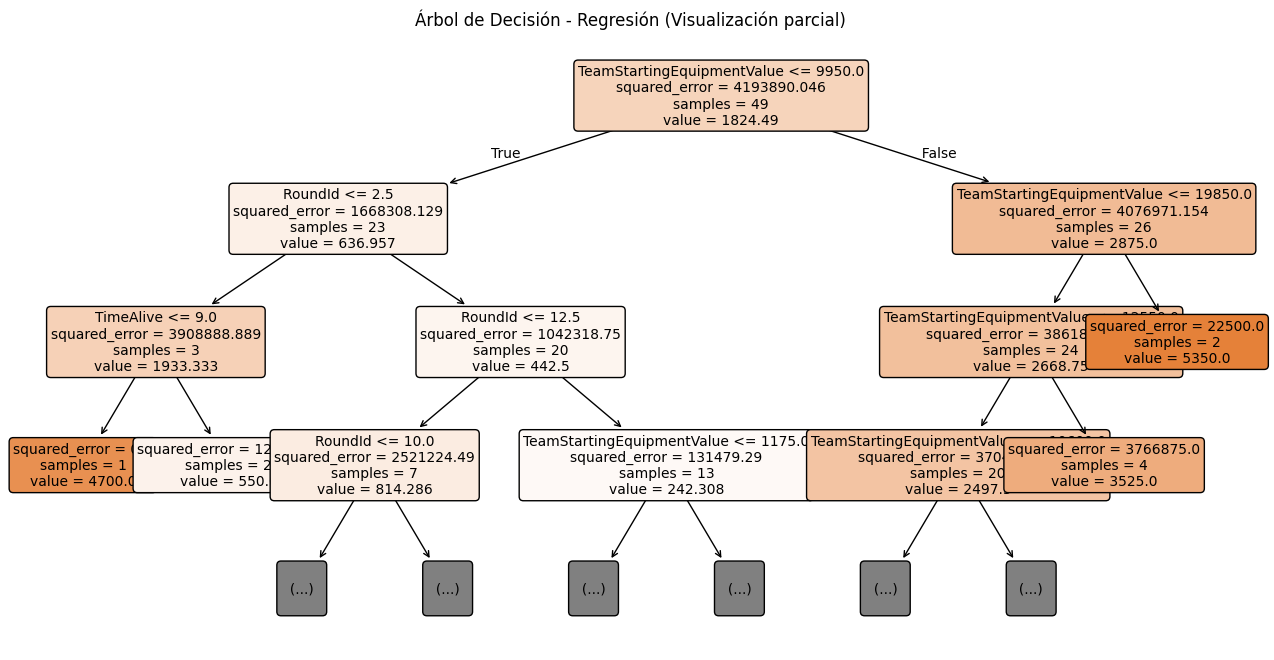

Mejor puntaje R² en CV: -0.0911
Mejores hiperparámetros: {'max_depth': 3, 'min_samples_split': 2}


,0
mean_fit_time,0.005002
std_fit_time,0.001408
mean_score_time,0.003336
std_score_time,0.000378
param_max_depth,3
param_min_samples_split,2
params,"{'max_depth': 3, 'min_samples_split': 2}"
split0_test_score,0.257838
split1_test_score,-0.649356
split2_test_score,0.277801


Evaluación del árbol optimizado en test - RMSE: 1829.73, R²: 0.28


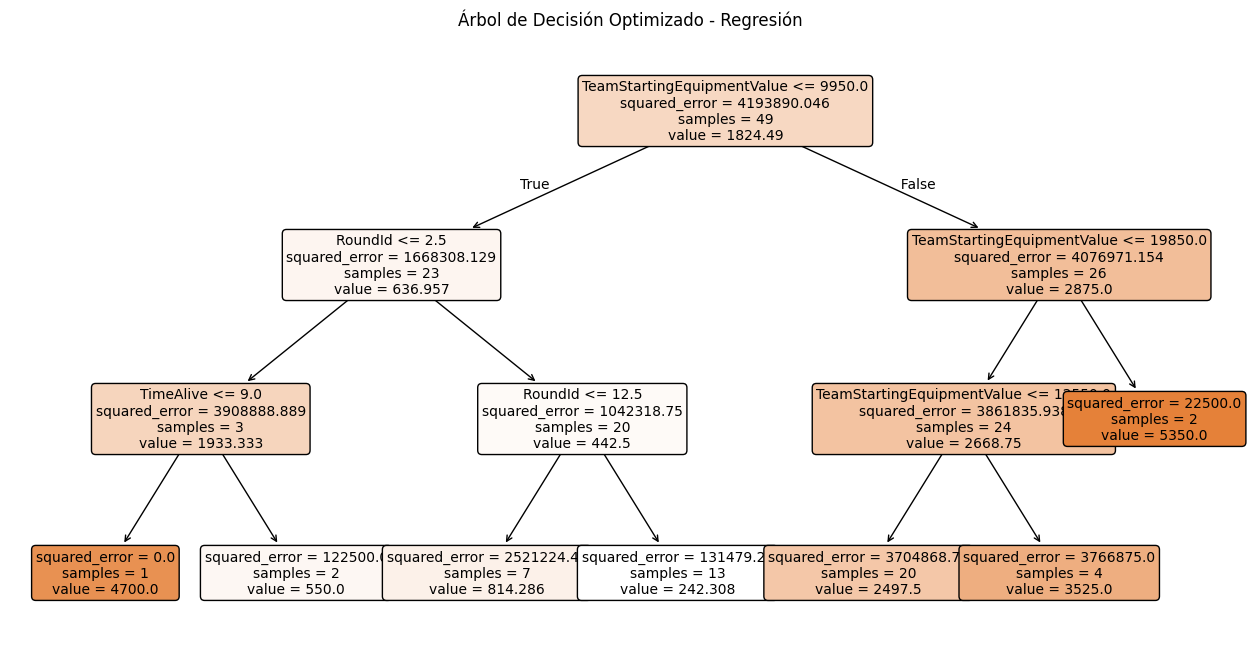

In [ ]:
# Variables objetivo y predictoras
target = df['RoundStartingEquipmentValue']
features = df[['TeamStartingEquipmentValue', 'RoundId', 'TimeAlive', 'RoundKills', 'TravelledDistance']]

# División en conjunto de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(features, target, train_size=0.7, random_state=42)

print(f"Datos de entrenamiento: {X_train.shape}")
print(f"Datos de prueba: {X_test.shape}")

# --- Entrenamiento de modelo base ---

arbol_regresion = DecisionTreeRegressor(random_state=42)
arbol_regresion.fit(X_train, y_train)

# --- Predicción y evaluación ---

predicciones = arbol_regresion.predict(X_test)

mse_val = mean_squared_error(y_test, predicciones)
rmse_val = np.sqrt(mse_val)
r2_val = r2_score(y_test, predicciones)

print(f'Raíz del Error Cuadrático Medio (RMSE): {rmse_val:.2f}')
print(f'Coeficiente de Determinación (R²): {r2_val:.2f}')

# --- Visualización del árbol base  ---

plt.figure(figsize=(16,8))
plot_tree(
    arbol_regresion,
    feature_names=features.columns,
    filled=True,
    rounded=True,
    max_depth=3,
    fontsize=10
)
plt.title('Árbol de Decisión - Regresión (Visualización parcial)')
plt.show()

# --- Ajuste fino con validación cruzada ---

parametros = {
    "max_depth": [3, 4, 5, 6],
    "min_samples_split": [2, 3, 4, 5]
}

modelo = DecisionTreeRegressor(random_state=42)

grid_search = GridSearchCV(modelo, param_grid=parametros, cv=5, scoring='r2')
grid_search.fit(X_train, y_train)

print(f"Mejor puntaje R² en CV: {grid_search.best_score_:.4f}")
print(f"Mejores hiperparámetros: {grid_search.best_params_}")

# Resultados completos de la búsqueda
resultados_df = pd.DataFrame(grid_search.cv_results_)
display(resultados_df.iloc[grid_search.best_index_])

# --- Evaluación del mejor modelo en datos de prueba ---

mejor_arbol = grid_search.best_estimator_

y_pred_mejor = mejor_arbol.predict(X_test)

mse_mejor = mean_squared_error(y_test, y_pred_mejor)
rmse_mejor = np.sqrt(mse_mejor)
r2_mejor = r2_score(y_test, y_pred_mejor)

print(f"Evaluación del árbol optimizado en test - RMSE: {rmse_mejor:.2f}, R²: {r2_mejor:.2f}")

# --- Visualización del árbol optimizado

plt.figure(figsize=(16,8))
plot_tree(
    mejor_arbol,
    feature_names=features.columns,
    filled=True,
    rounded=True,
    max_depth=3,
    fontsize=10
)
plt.title('Árbol de Decisión Optimizado - Regresión')
plt.show()

**5.- Random Forest**

🔍 Error cuadrático medio (MSE): 19.6996
📈 Coeficiente R2: 0.4901
🔍 Error absoluto medio (MAE): 3.0926


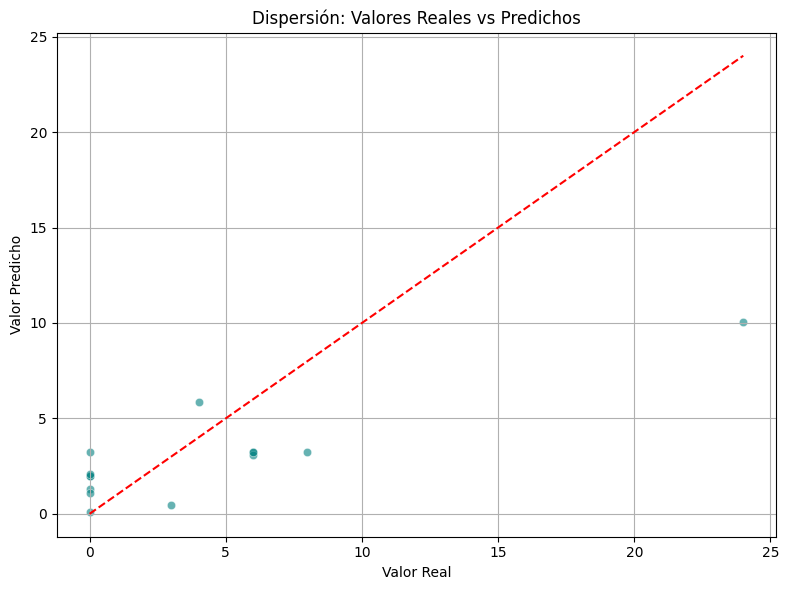

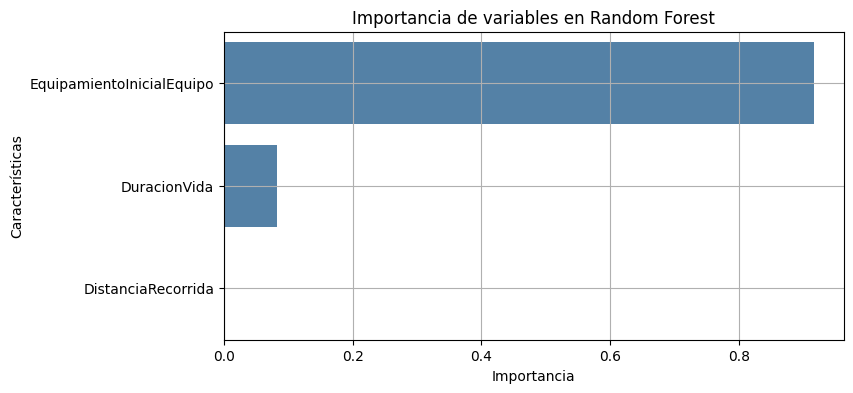

In [ ]:
# Definir las columnas predictoras y la variable objetivo
caracteristicas_rf = ['EquipamientoInicialEquipo', 'DuracionVida', 'DistanciaRecorrida']
variable_objetivo = 'TotalKills'

# Asegurarse de que las columnas sean numéricas
df_modelo[caracteristicas_rf + [variable_objetivo]] = df_modelo[caracteristicas_rf + [variable_objetivo]].apply(pd.to_numeric, errors='coerce')

# Eliminar filas con valores nulos
df_modelo = df_modelo.dropna(subset=caracteristicas_rf + [variable_objetivo])

# Separar las variables independientes (X) y dependiente (y)
X = df_modelo[caracteristicas_rf]
y = df_modelo[variable_objetivo]

# Dividir en conjunto de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Crear y entrenar el modelo Random Forest
modelo_rf = RandomForestRegressor(n_estimators=100, random_state=42)
modelo_rf.fit(X_train, y_train)

# Realizar predicciones
y_pred = modelo_rf.predict(X_test)

# Evaluar el modelo
mse_rf = mean_squared_error(y_test, y_pred)
r2_rf = r2_score(y_test, y_pred)

print(f"🔍 Error cuadrático medio (MSE): {mse_rf:.4f}")
print(f"📈 Coeficiente R2: {r2_rf:.4f}")

# Visualizar importancia de características
importancias = modelo_rf.feature_importances_

# Evaluar el modelo con métricas adicionales
mae_rf = mean_absolute_error(y_test, y_pred)

print(f"🔍 Error absoluto medio (MAE): {mae_rf:.4f}")

# Visualización: valores reales vs predichos
plt.figure(figsize=(8, 6))
sns.scatterplot(x=y_test, y=y_pred, alpha=0.6, color='teal')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel("Valor Real")
plt.ylabel("Valor Predicho")
plt.title("Dispersión: Valores Reales vs Predichos")
plt.grid(True)
plt.tight_layout()
plt.show()

print("\n")

plt.figure(figsize=(8, 4))
sns.barplot(x=importancias, y=caracteristicas_rf, color='steelblue')
plt.title("Importancia de variables en Random Forest")
plt.xlabel("Importancia")
plt.ylabel("Características")
plt.grid(True)
plt.show()

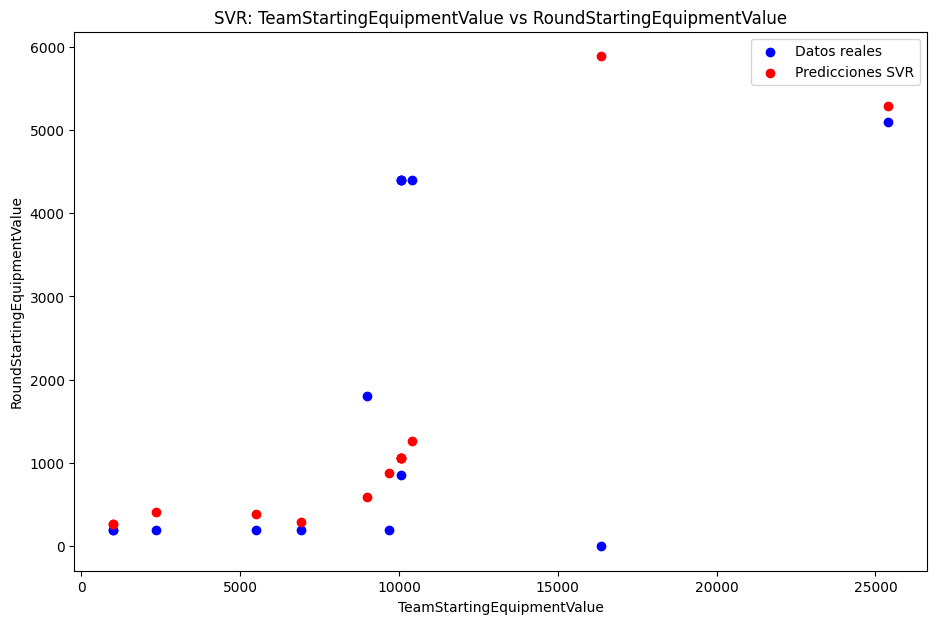

MSE: 5719380.0728
RMSE: 2391.5225
MAE: 1568.0939
R²: -0.40


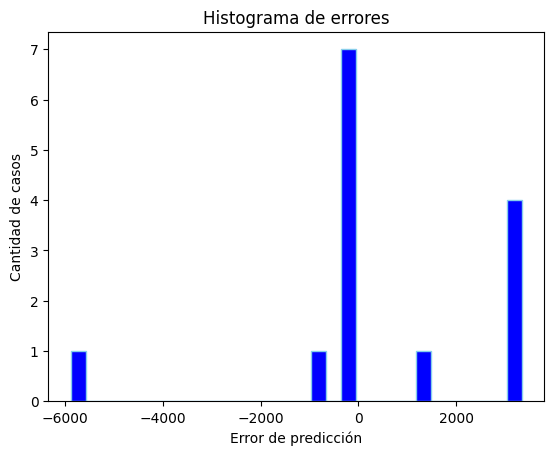

In [102]:
# Selección de características y objetivo
features = df[['TeamStartingEquipmentValue']].values  # Predictor
target = df['RoundStartingEquipmentValue'].values     # Variable a predecir

# División de datos en conjunto de entrenamiento y prueba
X_train, X_val, y_train, y_val = train_test_split(features, target, test_size=0.2, random_state=42)

# Normalización
scaler_features = RobustScaler(quantile_range=(25, 75))
scaler_target = RobustScaler()

X_train_norm = scaler_features.fit_transform(X_train)
X_val_norm = scaler_features.transform(X_val)

y_train_norm = scaler_target.fit_transform(y_train.reshape(-1, 1)).ravel()

# Definición y ajuste del modelo SVM
modelo_svr = SVR(kernel='rbf', C=1.0, epsilon=0.05)
modelo_svr.fit(X_train_norm, y_train_norm)

# Realizar predicciones y volver a la escala original
y_val_pred_norm = modelo_svr.predict(X_val_norm)
y_val_pred = scaler_target.inverse_transform(y_val_pred_norm.reshape(-1, 1)).ravel()

# Gráfica de comparación entre valores reales y predicciones
plt.figure(figsize=(11,7))
plt.scatter(X_val, y_val, color='blue', label='Datos reales')
plt.scatter(X_val, y_val_pred, color='red', label='Predicciones SVR')
plt.title('SVR: TeamStartingEquipmentValue vs RoundStartingEquipmentValue')
plt.xlabel('TeamStartingEquipmentValue')
plt.ylabel('RoundStartingEquipmentValue')
plt.legend()
plt.show()

# Cálculo de métricas para evaluar el modelo
error_cuadratico_medio = mean_squared_error(y_val, y_val_pred)
raiz_error_cuadratico = np.sqrt(error_cuadratico_medio)
error_absoluto_medio = mean_absolute_error(y_val, y_val_pred)
coef_r2 = r2_score(y_val, y_val_pred)

print(f"MSE: {error_cuadratico_medio:.4f}")
print(f"RMSE: {raiz_error_cuadratico:.4f}")
print(f"MAE: {error_absoluto_medio:.4f}")
print(f"R²: {coef_r2:.2f}")

# Histograma para visualizar la distribución de errores
diferencias = y_val - y_val_pred.flatten()

plt.hist(diferencias, bins=30, color='blue', edgecolor='skyblue')
plt.title('Histograma de errores')
plt.xlabel('Error de predicción')
plt.ylabel('Cantidad de casos')
plt.show()


**Comparativa final**

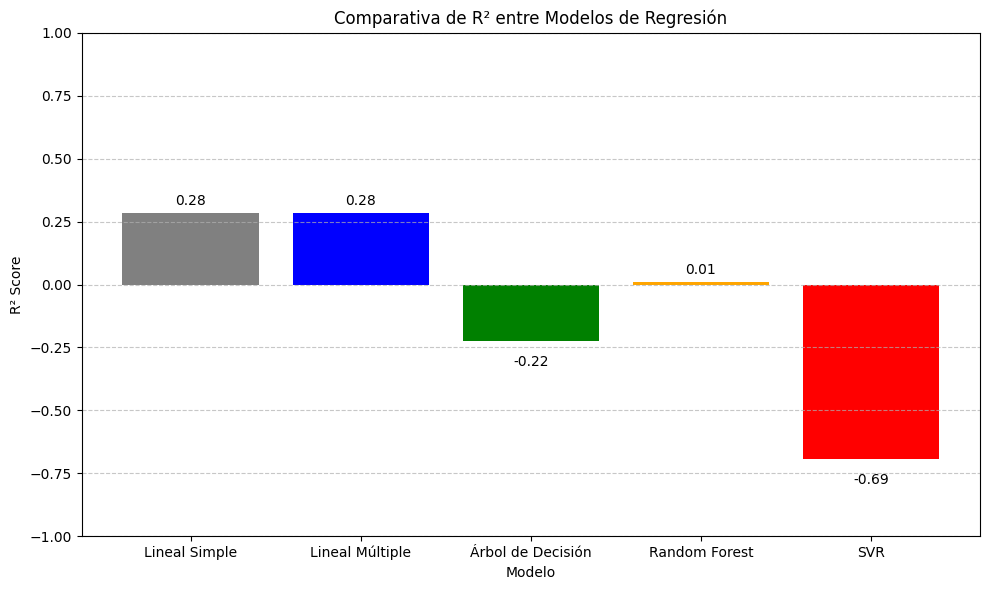

In [103]:
# Diccionario de modelos
modelos = {
    'Lineal Simple': LinearRegression(),
    'Lineal Múltiple': LinearRegression(),
    'Árbol de Decisión': DecisionTreeRegressor(max_depth=4, random_state=42),
    'Random Forest': RandomForestRegressor(n_estimators=100, random_state=42),
    'SVR': SVR(kernel='rbf', C=1.0, epsilon=0.05)
}

# Diccionario para guardar resultados de R²
resultados = {}

# Entrenamiento y evaluación
for nombre, modelo in modelos.items():
    if nombre == 'Lineal Simple':
        # Solo usamos una variable para la regresión simple
        X_train_simple = X_train[:, [0]]  # Por ejemplo, 'ronda_ct_ganadas'
        X_test_simple = X_test[:, [0]]
        modelo.fit(X_train_simple, y_train)
        y_pred = modelo.predict(X_test_simple)
    else:
        # Modelos multivariables
        modelo.fit(X_train, y_train)
        y_pred = modelo.predict(X_test)

    # Guardar R²
    r2 = r2_score(y_test, y_pred)
    resultados[nombre] = r2

# --- Gráfico comparativo de R² ---
plt.figure(figsize=(10, 6))
plt.bar(resultados.keys(), resultados.values(), color=['gray', 'blue', 'green', 'orange', 'red'])
plt.ylim(-1, 1)
plt.title('Comparativa de R² entre Modelos de Regresión')
plt.xlabel('Modelo')
plt.ylabel('R² Score')
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Mostrar valores sobre las barras
for i, (nombre, r2) in enumerate(resultados.items()):
    offset = 0.03 if r2 > 0 else -0.1
    plt.text(i, r2 + offset, f"{r2:.2f}", ha='center', fontsize=10)

plt.tight_layout()
plt.show()

Conclusión:
Los gráficos muestran que los modelos registrados lineales y multiples simples tenían el mejor rendimiento, logrando valores cercanos a 0.28. Esto significa que puede explicar alrededor del 28% de la variación de datos. No es un porcentaje muy alto, pero es significativamente más alto que el de otros modelos.

Por otro lado, el arbol decisivo mostró un rendimiento negativo con un valor de -0.22. Esto indica que la capacidad predictiva es peor que  usar el promedio como predicción. Lo mismo se aplica a los modelos SVM que logran resultados más bajos -0.69.

Finalmente, los bosques aleatorios que normalmente tenían un buen rendimiento recibieron muy bajos crudos 0.01. Esto indica que el modelo sufre más allá de la capacitación o es difícil de generalizar a los datos disponibles.